# The radial metallicity relation in simulated data

In [24]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
from sklearn.metrics import mean_squared_error
from matplotlib import gridspec
from matplotlib.colors import LogNorm
from scipy.stats import binned_statistic_2d

## Analysis of the Radial Metallicity Relation

The **radial metallicity relation** shows how metallicity—specifically, gas phase metallicity—varies with the galactocentric radius $R_{Gal}$. The gas phase metallicity is given by 

$$
A(O) = \log_{10} \left(\frac{N_O}{N_H}\right) + 12
$$

The relationship is crucial to understand the formation and evolutionary processes of galaxies, including phenomena such as inside-out formation, gas accretion, outflows, and radial migration. 

Significant progress has been achieved through observational studies (e.g., Ho et al., 2017, ApJ, 846, 39) and simulations (e.g., Grand et al., 2016, MNRAS, 460, 94). However, further investigation is essential for a comprehensive understanding of the radial metallicity gradient.

In this analysis, we will use data tracing the gas phase metallicity of a Milky Way analogue—a spiral galaxy. The simulation data is limited to the positions $(x, y, z)$ of the innermost gas particles (where $R_{Gal} < 25 \, \text{kpc})$ and their corresponding gas phase metallicity $A(O)$.


## Question 3.1 and 3.2 : Plotting and fitting the function

First, we will load the data using pandas, extract relevant information, and calculate necessary parameters for our analysis.

In [25]:
table =Table.read('data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits')
data= table.to_pandas()
print(data)


                x          y         z       A_O
0       10.020546 -15.421509 -3.241711  8.428943
1      -13.487837   5.663507 -0.802306  8.671107
2        6.642289  -0.138942 -0.585961  8.891596
3        0.203939   4.112373 -0.147622  8.977195
4      -20.824045   6.971037 -1.758061  8.326950
...           ...        ...       ...       ...
511515   1.533189   0.998079  0.217088  9.102036
511516   1.532199   0.998165  0.216980  9.102036
511517   1.698204  -1.207707  0.121088  9.081205
511518   1.698204  -1.206664  0.121917  9.081205
511519   1.698039  -1.206650  0.121900  9.081205

[511520 rows x 4 columns]


In [26]:
x = np.array(data['x']) # Extracts the 'x' column
y = np.array(data['y'])  # Extracts the 'y' column
z = np.array(data['z'])  # Extracts the 'z' column
AO = np.array(data['A_O'])  # Extracts the 'A_O' (gas phase metallicity) column

Calculate the radius of galaxy (RGal) from the $(x,y,z)$ data positions.

In [27]:
# Calculate RGal
RGal = np.sqrt(x**2 + y**2 + z**2)

To fit the data, we will use Python's `curve_fit` from the `scipy.optimize` module. We will provide an initial guess for the parameters of our fitting function. In this case, our initial guess is \([-0.1, 8.0]\).

In [28]:
# Define linear fit function
def linear_model(R, m, b):
    return m * R + b

# Fit the data
initial_guess = [-0.1, 8] 
popt, pcov = curve_fit(linear_model, RGal, AO, p0=initial_guess)
m, b = popt
m_err, b_err = np.sqrt(np.diag(pcov))

In [29]:
print(f"The value of slopes is {m:.5f} ± {m_err:.5f}")
print(f"The value of intercept is {b:.5f} ± {b_err:.5f}")


The value of slopes is -0.03325 ± 0.00002
The value of intercept is 9.12232 ± 0.00028


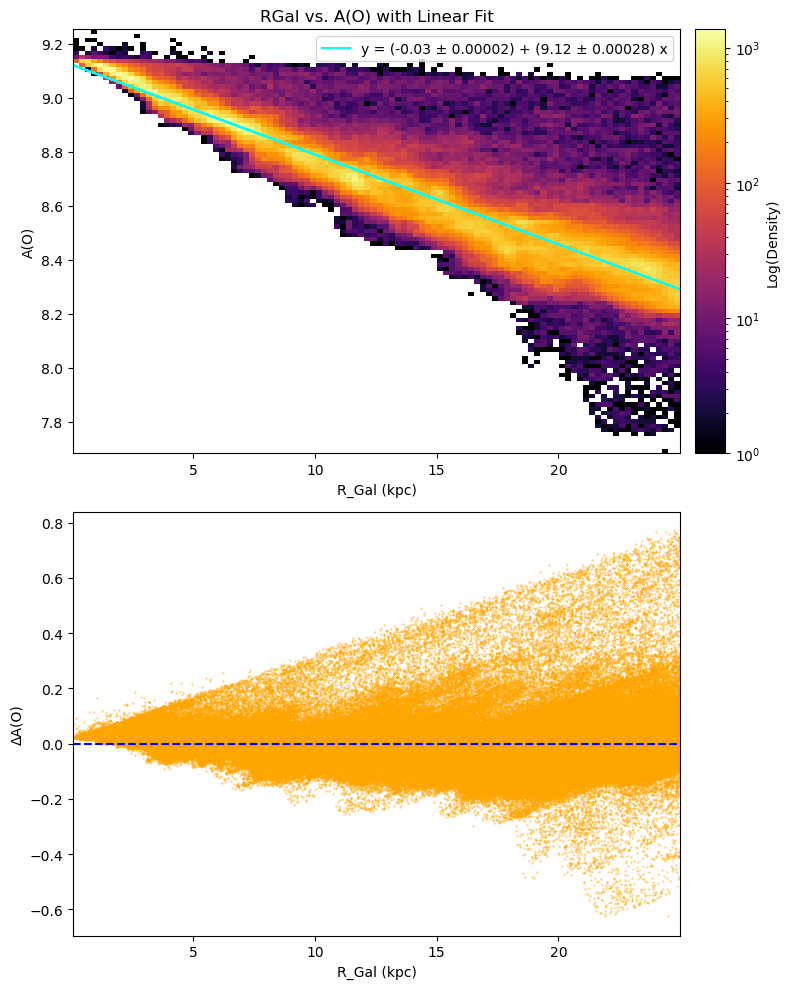

In [30]:
# Create a figure
plt.figure(figsize=(8, 10))

# Define the x-axis limits to keep both subplots aligned
x_limits = [np.min(RGal), np.max(RGal)]

# Create a gridspec with space for colorbar without shifting x-axis alignment
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1])  # Adjust the width ratio to fit the colorbar

# First subplot: Logarithmic density plot with linear fit
ax1 = plt.subplot(gs[0, 0])
hist = ax1.hist2d(RGal, AO, bins=100, cmap='inferno', norm=LogNorm())
ax1.plot(RGal, linear_model(RGal, *popt), color='cyan', 
         label=f"y = ({m:.2f} ± {m_err:.5f}) + ({b:.2f} ± {b_err:.5f}) x")
ax1.set_xlabel('R_Gal (kpc)')
ax1.set_ylabel('A(O)')
ax1.legend()
ax1.set_title('RGal vs. A(O) with Linear Fit')
ax1.set_xlim(x_limits)  # Set the x-axis limits

# Colorbar for the first plot
cbar_ax = plt.subplot(gs[0, 1])  # Place the colorbar next to the first plot
plt.colorbar(hist[3], cax=cbar_ax, label='Log(Density)')

# Calculate residuals
residuals = AO - linear_model(RGal, *popt)

# Second subplot: Residuals plot (with aligned x-axis)
ax2 = plt.subplot(gs[1, 0])
ax2.scatter(RGal, residuals, s=0.1, color='orange')
ax2.axhline(0, color='blue', linestyle='--')
ax2.set_xlabel('R_Gal (kpc)')
ax2.set_ylabel('ΔA(O)')
ax2.set_xlim(x_limits)  # Set the x-axis limits to match the first plot

# Adjust layout for better alignment
plt.tight_layout()
plt.savefig(f'figures/RGal_vs_A0.png')
# Display the plot
plt.show()




## Question 2.3 : Analyzation of the fit

The Root Mean Squared (RMS) is a statistical measure used to quantify the difference between predicted values and actual (observed) values. 

- Lower RMS indicates a better fit of the model to the data, meaning that the predictions are close to the actual values.
- Higher RMS indicates a poorer fit, with larger discrepancies between predictions and actual values.

In [31]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(AO, linear_model(RGal, *popt)))
print(f"RMSE: {rmse}")

RMSE: 0.08758016080877418


Here, we examine the root mean squared as a function of RGal (we split the data into 30 bins). 

Bin 1 (0.05 <= RGal < 0.88): RMS = 0.0295
Bin 2 (0.88 <= RGal < 1.71): RMS = 0.0348
Bin 3 (1.71 <= RGal < 2.55): RMS = 0.0356
Bin 4 (2.55 <= RGal < 3.38): RMS = 0.0358
Bin 5 (3.38 <= RGal < 4.21): RMS = 0.0377
Bin 6 (4.21 <= RGal < 5.04): RMS = 0.0401
Bin 7 (5.04 <= RGal < 5.87): RMS = 0.0392
Bin 8 (5.87 <= RGal < 6.70): RMS = 0.0390
Bin 9 (6.70 <= RGal < 7.54): RMS = 0.0421
Bin 10 (7.54 <= RGal < 8.37): RMS = 0.0553
Bin 11 (8.37 <= RGal < 9.20): RMS = 0.0624
Bin 12 (9.20 <= RGal < 10.03): RMS = 0.0601
Bin 13 (10.03 <= RGal < 10.86): RMS = 0.0629
Bin 14 (10.86 <= RGal < 11.69): RMS = 0.0665
Bin 15 (11.69 <= RGal < 12.53): RMS = 0.0731
Bin 16 (12.53 <= RGal < 13.36): RMS = 0.0824
Bin 17 (13.36 <= RGal < 14.19): RMS = 0.0838
Bin 18 (14.19 <= RGal < 15.02): RMS = 0.0848
Bin 19 (15.02 <= RGal < 15.85): RMS = 0.0874
Bin 20 (15.85 <= RGal < 16.68): RMS = 0.0992
Bin 21 (16.68 <= RGal < 17.52): RMS = 0.1008
Bin 22 (17.52 <= RGal < 18.35): RMS = 0.1055
Bin 23 (18.35 <= RGal < 19.18): RMS = 0.10

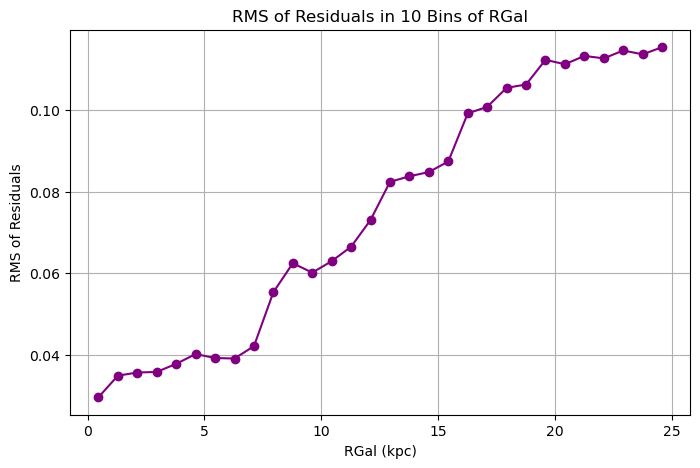

In [32]:
# Define the number of bins
num_bins = 30

# Create bins for RGal
RGal_min, RGal_max = np.min(RGal), np.max(RGal)
bins = np.linspace(RGal_min, RGal_max, num_bins + 1)

# Initialize a list to store the RMS in each bin
rms_per_bin = []

# Loop through each bin and calculate RMS
for i in range(num_bins):
    # Find indices of data points within the current bin
    bin_indices = np.where((RGal >= bins[i]) & (RGal < bins[i+1]))[0]
    
    # Get the residuals for this bin
    bin_residuals = residuals[bin_indices]
    
    # Calculate RMS for the residuals in this bin
    bin_rms = np.sqrt(np.mean(bin_residuals**2))
    
    # Store the result
    rms_per_bin.append(bin_rms)

    # Print results for each bin
    print(f"Bin {i+1} ({bins[i]:.2f} <= RGal < {bins[i+1]:.2f}): RMS = {bin_rms:.4f}")

# Optionally, plot the RMS per bin
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
bin_centers = (bins[:-1] + bins[1:]) / 2  # Find the center of each bin
plt.plot(bin_centers, rms_per_bin, marker='o', linestyle='-', color='purple')
plt.xlabel('RGal (kpc)')
plt.ylabel('RMS of Residuals')
plt.title('RMS of Residuals in 10 Bins of RGal')
plt.grid(True)
plt.savefig(f'figures/RMs_Residuals.png')
plt.show()


From our fitting results, we observe the following:

1. **RMS Behavior**: At the center of the galaxy(where $R_{Gal}$ is near zero), the Root Mean Square (RMS) error is quite small. This indicates a good fit between the data and the fitting function in this region. In contrast, as $R_{Gal}$ increases, the RMS error also increases, suggesting a poorer fit and higher uncertainty in our model at larger radii.

2. **Residuals Analysis**: The residuals plot further confirms this trend. At higher $R_{Gal}$ values, the residuals show greater variation compared to those at smaller $R_{Gal}$. This indicates that the fitting function does not capture the underlying data trends as effectively in the outer regions of the galaxy.


## Question 3.4 : 3-panel figure for the x vs. y plane

We generate 2D histograms for simulated A(O) data using `scipy.stats.binned_statistic_2d` and visualizes them with `matplotlib`. 

### Key Features:
- **Binning:** The data is binned into three different sizes: 30, 100, and 500.
- **Panels:**
  - **Panel 1:** Displays the median of simulated A(O).
  - **Panel 2:** Shows the median of fitted A(O).
  - **Panel 3:** Illustrates the median of residuals ∆A(O).
- **Output:** Each figure is saved in the `figures` directory with a resolution of 200 dpi.


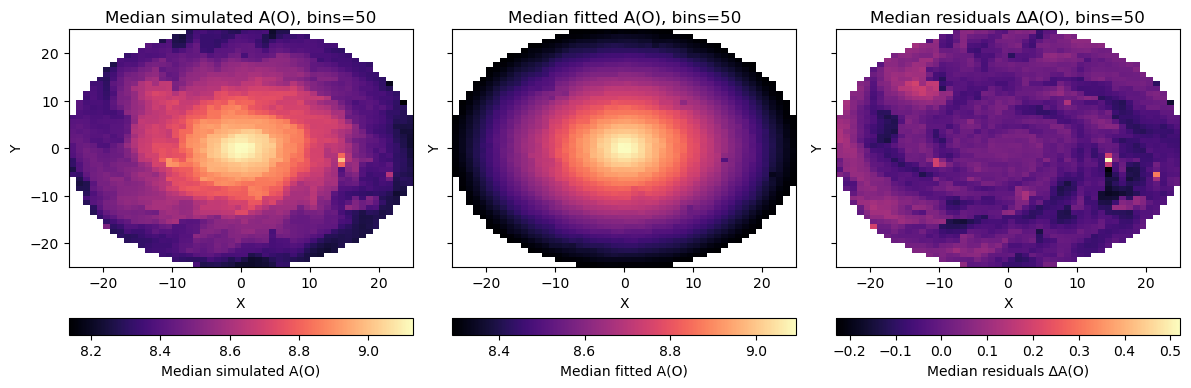

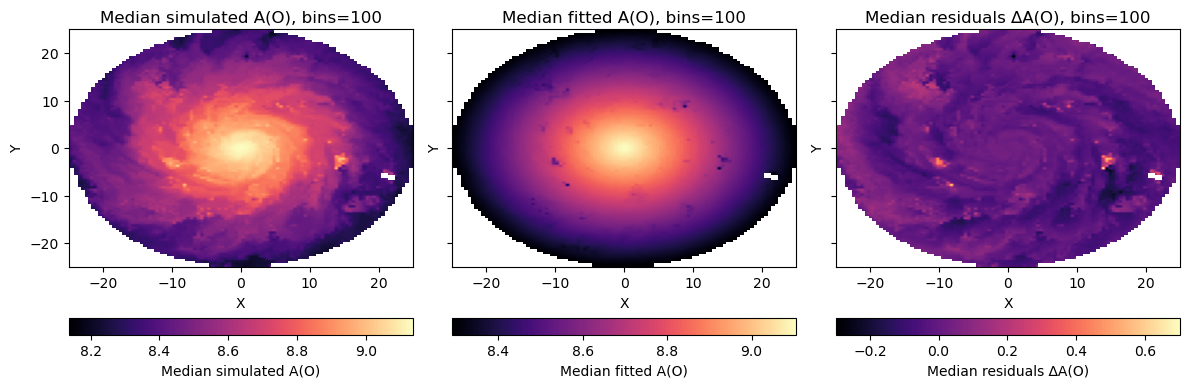

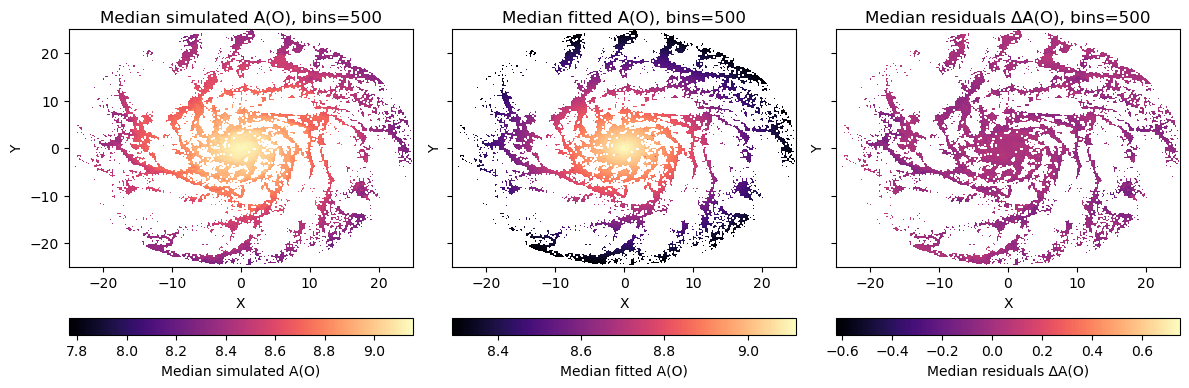

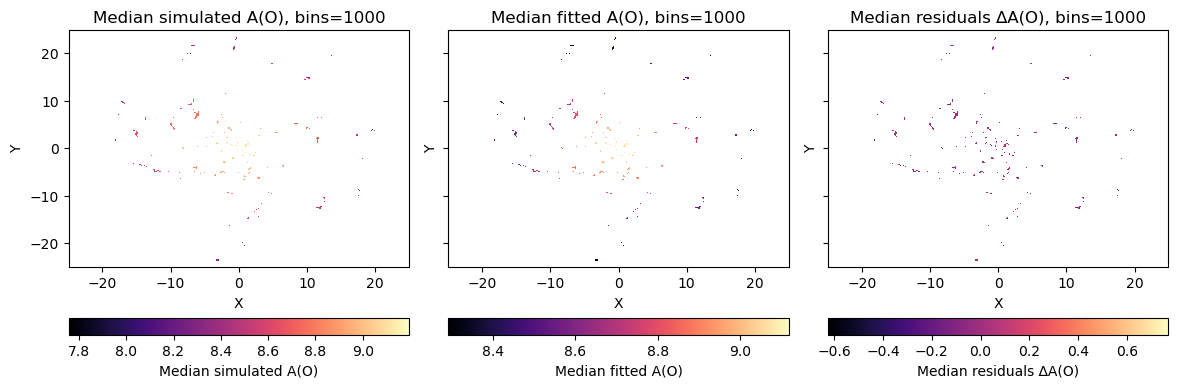

In [33]:
# Define bins and loop through them
bins_list = [50, 100, 500,1000]

for i, bins in enumerate(bins_list):
    # Create figure and subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

    # First panel: 2D histogram (binned stats) colored by median simulated A(O)
    bin_stat_median, xedges, yedges, binnumber = binned_statistic_2d(x, y, AO, statistic='median', bins=bins)
    im = axs[0].imshow(bin_stat_median.T, origin='lower', aspect='auto',
                       extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                       cmap='magma')
    axs[0].set_title(f"Median simulated A(O), bins={bins}")
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    plt.colorbar(im, ax=axs[0], label="Median simulated A(O)", orientation='horizontal')

    # Second panel: 2D histogram (binned stats) colored by median fitted A(O)
    bin_stat_median_fit, xedges, yedges, binnumber = binned_statistic_2d(x, y, linear_model(RGal, *popt), statistic='median', bins=bins)
    im2 = axs[1].imshow(bin_stat_median_fit.T, origin='lower', aspect='auto',
                        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                        cmap='magma')
    axs[1].set_title(f"Median fitted A(O), bins={bins}")
    axs[1].set_xlabel("X")
    axs[1].set_ylabel("Y")
    plt.colorbar(im2, ax=axs[1], label="Median fitted A(O)", orientation='horizontal')

    # Third panel: 2D histogram (binned stats) colored by median residuals
    bin_stat_median_residuals, xedges, yedges, binnumber = binned_statistic_2d(x, y, residuals, statistic='median', bins=bins)
    im3 = axs[2].imshow(bin_stat_median_residuals.T, origin='lower', aspect='auto',
                        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                        cmap='magma')
    axs[2].set_title(f"Median residuals ∆A(O), bins={bins}")
    axs[2].set_xlabel("X")
    axs[2].set_ylabel("Y")
    plt.colorbar(im3, ax=axs[2], label="Median residuals ∆A(O)", orientation='horizontal')

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(f'figures/x_y_2d_histogram_bins_{bins}.png', dpi=200)
    plt.show()  # Close the figure after saving to avoid displaying it


# Question 3.5

In this analysis, I utilized a list of bins: `bins_list = [50, 100, 500, 1000]` to explore how different bin sizes affect the visualization of our data.

1. **Bins = 50**: The resulting figure lacks smoothness, making it difficult to discern finer details. The low number of bins leads to a coarse representation of the data distribution, obscuring important features.

2. **Bins = 100**: This configuration appears to be the optimal choice for bin size. The features of the data are clearly visible, providing a good balance between detail and clarity. It captures the distribution effectively without oversimplifying the data.

3. **Bins = 500**: At this bin size, we begin to lose some of the significant features present in the data. The increased number of bins causes the data to become fragmented, leading to a less coherent visualization.

4. **Bins = 1000**: With this configuration, most of the critical features of the diagram are lost. The high bin count results in an overly detailed representation.


# Question 3.6

From the residual plot above, we observe that the residuals increase as $R_{Gal}$ grows, indicating that the fitting function struggles to capture the data trends in the outer regions of the galaxy. This discrepancy may have several physical explanations, including the inhomogeneous distribution of matter in the outer parts, which is a common characteristic of spiral galaxies.